# 2025 Python libraries
- Presenter: Jake Krol
- Notebook contents inspired by Erik Johnson and Michael Bradshaw

## Purpose
- Gain hands-on experience with NumPy, Pandas, Matplotlib, and other libraries

## Methods
- Regression
- Hypothesis testing
- Gini Coefficient and Lorenz curve

## Topics
- Climate change
- Population equilibrium
- Rice production "wealth"

## Related work
- Lecture slides: https://docs.google.com/presentation/d/1eq1OidZWZSqgBQHWibpLE_m3-_NNYqYcCeVR95GhkMc/edit?usp=sharing

## Setup
- Upload `agrofood_co2_emission.csv` file

## Scenario
You work for a data science consulting firm, and your supervisor sends you some data with minimal context. Your task is to understand what the data encodes and what insights are attainable purely from the dataset.

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
import re
import scipy.stats as stats

## Basic inspection

In [37]:
# read
# view shape
df = pd.read_csv('agrofood_co2_emission.csv')
print('# shape ', df.shape)

# shape  (6965, 31)


In [38]:
# preview
df.head()

,Area,Year,Savanna fires,Forest fires,Crop Residues,Rice Cultivation,Drained organic soils (CO2),Pesticides Manufacturing,Food Transport,Forestland,...,Manure Management,Fires in organic soils,Fires in humid tropical forests,On-farm energy use,Rural population,Urban population,Total Population - Male,Total Population - Female,total_emission,Average Temperature °C
0,Afghanistan,1990,14.7237,0.0557,205.6077,686.00,0.0,11.807483,63.1152,-2388.803,...,319.1763,0.0,0.0,NaN,9655167.0,2593947.0,5348387.0,5346409.0,2198.963539,0.536167
1,Afghanistan,1991,14.7237,0.0557,209.4971,678.16,0.0,11.712073,61.2125,-2388.803,...,342.3079,0.0,0.0,NaN,10230490.0,2763167.0,5372959.0,5372208.0,2323.876629,0.020667
2,Afghanistan,1992,14.7237,0.0557,196.5341,686.00,0.0,11.712073,53.3170,-2388.803,...,349.1224,0.0,0.0,NaN,10995568.0,2985663.0,6028494.0,6028939.0,2356.304229,-0.259583
3,Afghanistan,1993,14.7237,0.0557,230.8175,686.00,0.0,11.712073,54.3617,-2388.803,...,352.2947,0.0,0.0,NaN,11858090.0,3237009.0,7003641.0,7000119.0,2368.470529,0.101917
4,Afghanistan,1994,14.7237,0.0557,242.0494,705.60,0.0,11.712073,53.9874,-2388.803,...,367.6784,0.0,0.0,NaN,12690115.0,3482604.0,7733458.0,7722096.0,2500.768729,0.372250


In [39]:
# count column data types
df.dtypes.value_counts()

float64    29
object      1
int64       1
Name: count, dtype: int64

checkpoint
  - Agricultural data
  - For various (area,year) combinations, there exists numeric features
    - e.g., Afghan 1990 rice cultivation
questions
- How many distinct countries exist in df?
- What is the year span?
- What are the units of measurement for these columns?
- What are mean/expected values in each numeric column?


In [40]:
# distinct areas
print(df['Area'].nunique())
print(df['Area'].unique()[:10])

236
['Afghanistan' 'Albania' 'Algeria' 'American Samoa' 'Andorra' 'Angola'
 'Anguilla' 'Antigua and Barbuda' 'Argentina' 'Armenia']


In [41]:
# year span
print(
    df['Year'].min(),
    df['Year'].max()
)

1990 2020


In [42]:
df[df.columns.drop(['Area', 'Year'])].describe().T['mean'].round(2)

Savanna fires                          1188.39
Forest fires                            919.30
Crop Residues                           998.71
Rice Cultivation                       4259.67
Drained organic soils (CO2)            3503.23
Pesticides Manufacturing                333.42
Food Transport                         1939.58
Forestland                           -17828.29
Net Forest conversion                 17605.64
Food Household Consumption             4847.58
Food Retail                            2043.21
On-farm Electricity Use                1626.68
Food Packaging                         1658.63
Agrifood Systems Waste Disposal        6018.44
Food Processing                        3872.72
Fertilizers Manufacturing              3035.72
IPPU                                  19991.50
Manure applied to Soils                 923.23
Manure left on Pasture                 3518.03
Manure Management                      2263.34
Fires in organic soils                 1210.32
Fires in humi

questions
- why is forestland negative? is change in forestland measured?
- given this data, what hypotheses could we form?
  - let's get a frame of reference by inspecting one area/country

In [43]:
df_usa=df[df['Area'] == 'United States of America']
df_usa.head()

,Area,Year,Savanna fires,Forest fires,Crop Residues,Rice Cultivation,Drained organic soils (CO2),Pesticides Manufacturing,Food Transport,Forestland,...,Manure Management,Fires in organic soils,Fires in humid tropical forests,On-farm energy use,Rural population,Urban population,Total Population - Male,Total Population - Female,total_emission,Average Temperature °C
6591,United States of America,1990,1391.1481,1999.5617,19193.1314,11195.520,50713.3546,13772.0,45410.2673,-520573.1593,...,47024.7024,0.0,9.8513,54454.7092,62373717.0,190156233.0,121451448.0,126632284.0,463050.9394,0.733583
6592,United States of America,1991,1391.1481,1999.5617,17574.1126,11029.312,50713.3546,13139.0,44566.9408,-520573.1593,...,48206.0451,0.0,9.8513,54565.6091,61957131.0,193017688.0,123229931.0,128330258.0,473285.7816,0.706333
6593,United States of America,1992,1391.1481,1999.5617,20964.8025,12421.402,50713.3546,14109.0,46198.5933,-520573.1593,...,48416.2439,0.0,9.8513,57469.9273,61539241.0,195915032.0,125081499.0,130093840.0,486026.3425,0.253000
6594,United States of America,1993,1391.1481,1999.5617,16761.5327,11235.602,50566.2744,12948.0,45175.6740,-520573.1593,...,48426.0899,0.0,9.8513,54689.3180,61136396.0,198883790.0,126914111.0,131865642.0,484238.6197,0.153500
6595,United States of America,1994,1391.1481,1999.5617,21370.6468,13151.110,50418.1314,14401.0,46739.0889,-520573.1593,...,49165.7227,0.0,9.8513,55539.8937,60759735.0,201981831.0,128685441.0,133588147.0,509412.4984,0.470250


questions
- we have savannas in the USA?
- does avg. temp support climate warming hypotheses?
- are urban/rural populations shrinking/growing?

In [44]:
# graph avg temp over time in the US
# plt.plot(df_usa['Year'], df_usa['AvgTemp'])
# plt.show()

- oh, that's very annoying. the temperature column uses the '°' character ...

- what's a simple way to resolve this?

In [45]:
# let's clean up column names
def cln(x):
    x = x.replace('°','')
    # whitespace
    x = re.sub(r"\s+", "_", x)
    # hyphens
    x = x.replace('-','_')
    # parentheses
    x = x.replace('(', '')
    x = x.replace(')', '')
    # redundant '_' removal
    x = re.sub(r"_+", "_", x)
    # lower
    return x.lower()
df.columns = [cln(x) for x in df.columns]
df.head()

,area,year,savanna_fires,forest_fires,crop_residues,rice_cultivation,drained_organic_soils_co2,pesticides_manufacturing,food_transport,forestland,...,manure_management,fires_in_organic_soils,fires_in_humid_tropical_forests,on_farm_energy_use,rural_population,urban_population,total_population_male,total_population_female,total_emission,average_temperature_c
0,Afghanistan,1990,14.7237,0.0557,205.6077,686.00,0.0,11.807483,63.1152,-2388.803,...,319.1763,0.0,0.0,NaN,9655167.0,2593947.0,5348387.0,5346409.0,2198.963539,0.536167
1,Afghanistan,1991,14.7237,0.0557,209.4971,678.16,0.0,11.712073,61.2125,-2388.803,...,342.3079,0.0,0.0,NaN,10230490.0,2763167.0,5372959.0,5372208.0,2323.876629,0.020667
2,Afghanistan,1992,14.7237,0.0557,196.5341,686.00,0.0,11.712073,53.3170,-2388.803,...,349.1224,0.0,0.0,NaN,10995568.0,2985663.0,6028494.0,6028939.0,2356.304229,-0.259583
3,Afghanistan,1993,14.7237,0.0557,230.8175,686.00,0.0,11.712073,54.3617,-2388.803,...,352.2947,0.0,0.0,NaN,11858090.0,3237009.0,7003641.0,7000119.0,2368.470529,0.101917
4,Afghanistan,1994,14.7237,0.0557,242.0494,705.60,0.0,11.712073,53.9874,-2388.803,...,367.6784,0.0,0.0,NaN,12690115.0,3482604.0,7733458.0,7722096.0,2500.768729,0.372250


In [46]:
# clean usa subset
df_usa.columns = [cln(x) for x in df_usa.columns]
df_usa.head()

,area,year,savanna_fires,forest_fires,crop_residues,rice_cultivation,drained_organic_soils_co2,pesticides_manufacturing,food_transport,forestland,...,manure_management,fires_in_organic_soils,fires_in_humid_tropical_forests,on_farm_energy_use,rural_population,urban_population,total_population_male,total_population_female,total_emission,average_temperature_c
6591,United States of America,1990,1391.1481,1999.5617,19193.1314,11195.520,50713.3546,13772.0,45410.2673,-520573.1593,...,47024.7024,0.0,9.8513,54454.7092,62373717.0,190156233.0,121451448.0,126632284.0,463050.9394,0.733583
6592,United States of America,1991,1391.1481,1999.5617,17574.1126,11029.312,50713.3546,13139.0,44566.9408,-520573.1593,...,48206.0451,0.0,9.8513,54565.6091,61957131.0,193017688.0,123229931.0,128330258.0,473285.7816,0.706333
6593,United States of America,1992,1391.1481,1999.5617,20964.8025,12421.402,50713.3546,14109.0,46198.5933,-520573.1593,...,48416.2439,0.0,9.8513,57469.9273,61539241.0,195915032.0,125081499.0,130093840.0,486026.3425,0.253000
6594,United States of America,1993,1391.1481,1999.5617,16761.5327,11235.602,50566.2744,12948.0,45175.6740,-520573.1593,...,48426.0899,0.0,9.8513,54689.3180,61136396.0,198883790.0,126914111.0,131865642.0,484238.6197,0.153500
6595,United States of America,1994,1391.1481,1999.5617,21370.6468,13151.110,50418.1314,14401.0,46739.0889,-520573.1593,...,49165.7227,0.0,9.8513,55539.8937,60759735.0,201981831.0,128685441.0,133588147.0,509412.4984,0.470250


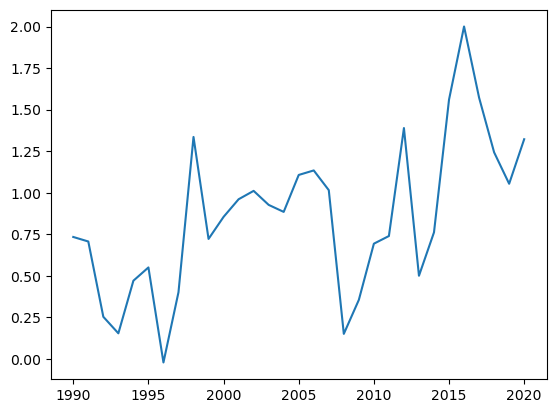

In [47]:
# is climate warming hypothesis supported by USA data?
x = df_usa['year']
y = df_usa['average_temperature_c']
plt.plot(x,y)

interesting, there's an upward trend.

Q: how could we simply, numerically quantify this trend?

<details>
<summary>Click to reveal spoiler</summary>

linear regression

</details>

## Climate change regression

In [48]:
# regression with OLS objective
# using scipy
slope, intercept, r_value, p_value, std_err = stats.linregress(
    x,
    y,
    alternative='greater'
)
print(
    'slope: ', slope,
    '\nintercept: ', intercept,
    '\nr_value: ', r_value,
    '\np_value: ', p_value,
    '\nstd_err: ', std_err
)

slope:  0.02962479838709677 
intercept:  -58.5416320564516 
r_value:  0.5784210865537276 
p_value:  0.0003266897078220169 
std_err:  0.007758239185112271


checkpoint: regression analysis
- how can we visualize our regression line
- why did we get a p-value? how do we interpret it in this context? (hint: what did we talk about in monte carlo hypothesis testing?)

<details>
<summary>Click to reveal spoiler</summary>

- slope and intercept provide the linear equation; therefore, we can plug in arbitrary inputs in the domain $x \in R$. we're interested

</details>

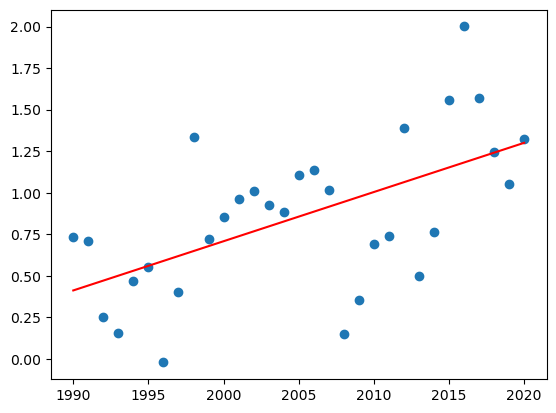

In [49]:
# plot fit regression line and data
plt.plot(x, y, 'o')
plt.plot(x, intercept + slope*x, 'r')
plt.show()

Yes, from the data, we can **reject the null hypothesis** ($p=.00032$) that average temperature is non-increasing over time ... in the USA.

What about other countries? How would you design and implement this experiment on a larger scale?

/data/jake/miniconda3/lib/python3.12/site-packages/scipy/stats/_stats_py.py:10729: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/data/jake/miniconda3/lib/python3.12/site-packages/scipy/stats/_stats_py.py:10743: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/data/jake/miniconda3/lib/python3.12/site-packages/scipy/stats/_stats_py.py:10749: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


(array([227.,   2.,   0.,   1.,   2.,   0.,   0.,   0.,   2.,   1.]),
 array([0.        , 0.09962106, 0.19924212, 0.29886318, 0.39848424,
        0.49810531, 0.59772637, 0.69734743, 0.79696849, 0.89658955,
        0.99621061]),
 <BarContainer object of 10 artists>)

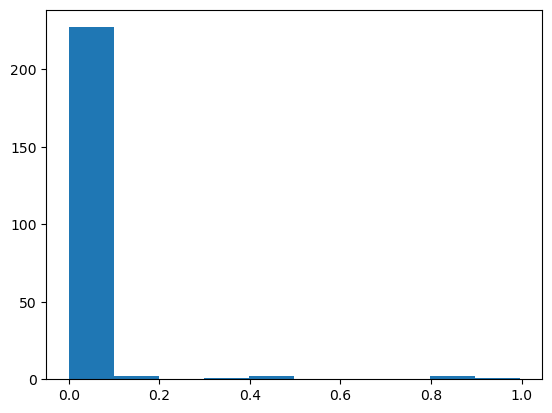

In [50]:
def gwarm_exp(years, avg_temps):
    slope, _, _, p_value, _ = stats.linregress(
      years,
      avg_temps,
      alternative='greater'
    )
    return p_value, slope
# apply this experiment to all areas
p_values = []
slopes = []
for group, df_group in df.groupby('area'):
    p_value, slope = gwarm_exp(df_group['year'], df_group['average_temperature_c'])
    p_values.append(p_value)
    slopes.append(slope)
# plot distribution of p-values
plt.hist(p_values)


most p-values are close to zero. But, $∃$ some $p>>0$.

How can we make this plot better?

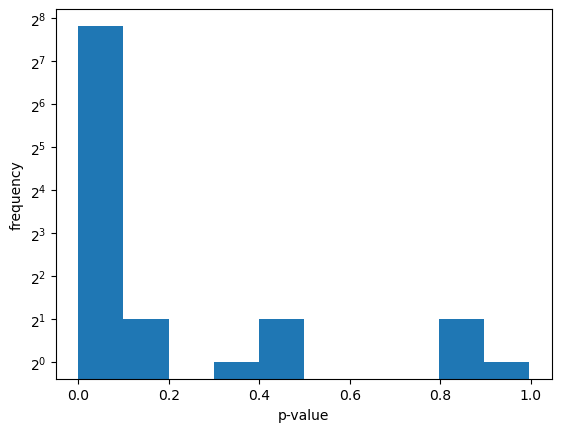

In [51]:
plt.hist(p_values)
plt.yscale("log", base = 2)
plt.xlabel("p-value")
plt.ylabel("frequency")
plt.show()

now, high p-values can easily be counted (cases where climate warming hyp was not supported).

i counted 8.

let's be more precise

In [52]:
# what fraction of areas support climate warming hypothesis
# try diff alpha and see how fraction changes
alpha = 0.05
n = len(p_values)
num = [p < alpha for p in p_values].count(True)
print(num/n)

0.940677966101695


conclusion: 94% of areas in our dataset support a climate warming hypothesis

we showed that temperature is rising, but to what degree and in which places?

(array([  1.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   0., 232.]),
 array([-1.21991667, -1.09021346, -0.96051025, -0.83080704, -0.70110383,
        -0.57140062, -0.44169741, -0.3119942 , -0.18229099, -0.05258778,
         0.07711544]),
 <BarContainer object of 10 artists>)

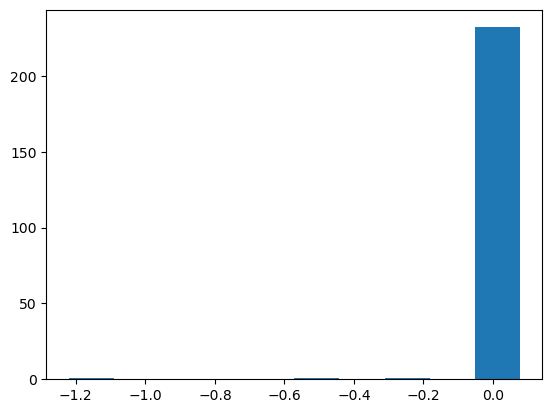

In [53]:
plt.hist(slopes)

clearly many slopes are close to zero, ... however, the tail of this distribution is interesting.

some places have a strong decrease in temp over the years

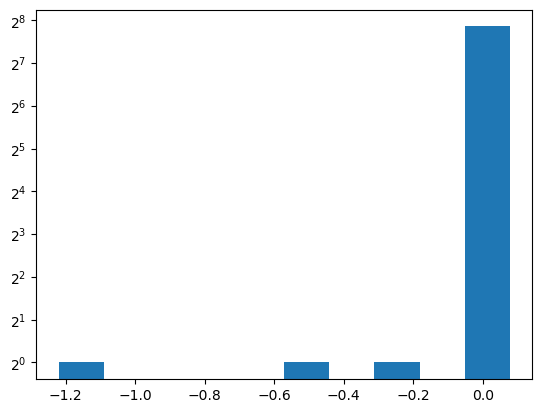

In [54]:
# again we scale y-axis for better view of dist. tail
plt.hist(slopes)
plt.yscale("log", base = 2)
plt.show()

two paths
1. i want to show evidence against climate warming
2. i want to show evidence supporting climate warming

In [55]:
# path 1
# goal: find outlier areas where avg temp is decreasing sharply
p_values_cherry = []
slopes_cherry = []
groups_cherry = []
for group, df_group in df.groupby('area'):
    p_value, slope = gwarm_exp(df_group['year'], df_group['average_temperature_c'])
    if slope < -0.1:
        p_values_cherry.append(p_value)
        slopes_cherry.append(slope)
        groups_cherry.append(group)
groups_cherry

/data/jake/miniconda3/lib/python3.12/site-packages/scipy/stats/_stats_py.py:10729: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/data/jake/miniconda3/lib/python3.12/site-packages/scipy/stats/_stats_py.py:10743: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/data/jake/miniconda3/lib/python3.12/site-packages/scipy/stats/_stats_py.py:10749: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


['Ethiopia PDR', 'USSR', 'Yugoslav SFR']

In [56]:
# path 1 cont.
df_cherry = df[df['area'].isin(groups_cherry)]
df_cherry.head()

,area,year,savanna_fires,forest_fires,crop_residues,rice_cultivation,drained_organic_soils_co2,pesticides_manufacturing,food_transport,forestland,...,manure_management,fires_in_organic_soils,fires_in_humid_tropical_forests,on_farm_energy_use,rural_population,urban_population,total_population_male,total_population_female,total_emission,average_temperature_c
2152,Ethiopia PDR,1990,3851.3866,1509.6419,349.6276,3391.507802,5513.0102,12.850182,100.5070,-107.2750,...,1543.7229,0.0,416.3368,80.8401,44542203.0,6657624.0,24890395.0,25137639.0,65914.320714,0.625000
2153,Ethiopia PDR,1991,3851.3866,1509.6419,286.8652,3309.287814,5513.0102,12.098396,98.8585,-107.2750,...,1554.3704,0.0,416.3368,82.1289,45925516.0,7022864.0,25886400.0,26090250.0,61115.468490,0.342667
2154,Ethiopia PDR,1992,3851.3866,1509.6419,270.0245,3586.696796,5513.0102,11.606165,33.8336,-107.2750,...,1594.3863,0.0,416.3368,41.6932,47359180.0,7407170.0,26890139.0,27042568.0,61654.073430,0.048444
6684,USSR,1990,8405.2264,7262.4148,14854.7660,4813.760000,131838.2352,1169.000000,32821.6716,-605722.9991,...,60407.5004,0.0,0.0000,248879.1769,99158922.0,188910774.0,136777703.0,153126995.0,524473.945541,1.158250
6685,USSR,1991,8405.2264,7262.4148,11900.4386,4699.296000,131838.2352,1301.000000,32500.3786,-605722.9991,...,59296.5706,0.0,0.0000,246785.4967,99725999.0,189602194.0,137641632.0,153853429.0,520480.833615,0.609000


/tmp/ipykernel_3250460/3954201872.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x_eth = df_cherry[df['area'] == 'Ethiopia PDR']['year']
/tmp/ipykernel_3250460/3954201872.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y_eth = df_cherry[df['area'] == 'Ethiopia PDR']['average_temperature_c']
/tmp/ipykernel_3250460/3954201872.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x_ussr = df_cherry[df['area'] == 'USSR']['year']
/tmp/ipykernel_3250460/3954201872.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y_ussr = df_cherry[df['area'] == 'USSR']['average_temperature_c']
/tmp/ipykernel_3250460/3954201872.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x_yugo = df_cherry[df['area'] == 'Yugoslav SFR']['year']
/tmp/ipykernel_3250460/3954201872.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame 

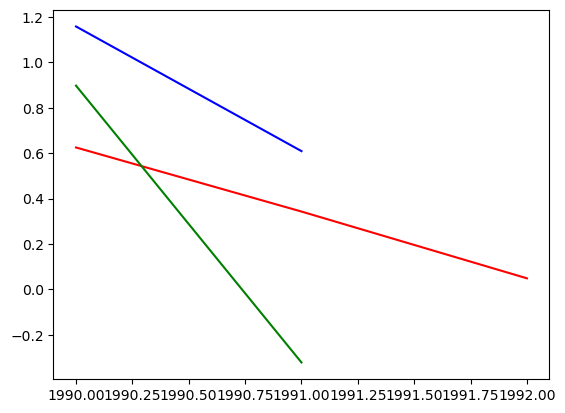

In [57]:
# path 2 cont.
x_eth = df_cherry[df['area'] == 'Ethiopia PDR']['year']
y_eth = df_cherry[df['area'] == 'Ethiopia PDR']['average_temperature_c']
plt.plot(x_eth, y_eth, 'r')
x_ussr = df_cherry[df['area'] == 'USSR']['year']
y_ussr = df_cherry[df['area'] == 'USSR']['average_temperature_c']
plt.plot(x_ussr, y_ussr, 'b')
x_yugo = df_cherry[df['area'] == 'Yugoslav SFR']['year']
y_yugo = df_cherry[df['area'] == 'Yugoslav SFR']['average_temperature_c']
plt.plot(x_yugo, y_yugo, 'g')
plt.show()


the data available for these countires is only from a few years

In [58]:
# observe year span of 1990-1991/1992
df_cherry

,area,year,savanna_fires,forest_fires,crop_residues,rice_cultivation,drained_organic_soils_co2,pesticides_manufacturing,food_transport,forestland,...,manure_management,fires_in_organic_soils,fires_in_humid_tropical_forests,on_farm_energy_use,rural_population,urban_population,total_population_male,total_population_female,total_emission,average_temperature_c
2152,Ethiopia PDR,1990,3851.3866,1509.6419,349.6276,3391.507802,5513.0102,12.850182,100.5070,-107.2750,...,1543.7229,0.0,416.3368,80.8401,44542203.0,6657624.0,24890395.0,25137639.0,65914.320714,0.625000
2153,Ethiopia PDR,1991,3851.3866,1509.6419,286.8652,3309.287814,5513.0102,12.098396,98.8585,-107.2750,...,1554.3704,0.0,416.3368,82.1289,45925516.0,7022864.0,25886400.0,26090250.0,61115.468490,0.342667
2154,Ethiopia PDR,1992,3851.3866,1509.6419,270.0245,3586.696796,5513.0102,11.606165,33.8336,-107.2750,...,1594.3863,0.0,416.3368,41.6932,47359180.0,7407170.0,26890139.0,27042568.0,61654.073430,0.048444
6684,USSR,1990,8405.2264,7262.4148,14854.7660,4813.760000,131838.2352,1169.000000,32821.6716,-605722.9991,...,60407.5004,0.0,0.0000,248879.1769,99158922.0,188910774.0,136777703.0,153126995.0,524473.945541,1.158250
6685,USSR,1991,8405.2264,7262.4148,11900.4386,4699.296000,131838.2352,1301.000000,32500.3786,-605722.9991,...,59296.5706,0.0,0.0000,246785.4967,99725999.0,189602194.0,137641632.0,153853429.0,520480.833615,0.609000
6901,Yugoslav SFR,1990,17.5124,27.8984,844.4150,69.619200,276.0991,40.000000,1874.2445,-10843.0573,...,4584.6630,0.0,0.0000,836.4433,11929250.0,11445927.0,10758632.0,11248553.0,28161.400700,0.897500
6902,Yugoslav SFR,1991,17.5124,27.8984,1047.9798,68.145300,276.0991,34.000000,1727.6882,-10843.0573,...,4502.9731,0.0,0.0000,776.2953,11824752.0,11526722.0,10733004.0,11229798.0,24271.147832,-0.322417


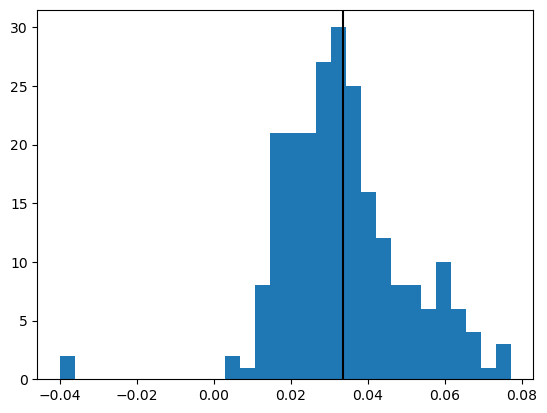

In [59]:
# path 2
# slope distribution excluding outliers
slopes_filt = [i for i in slopes if i > -0.1]
plt.hist(slopes_filt,bins=30)
plt.axvline(x=np.mean(slopes_filt),color='black')

using regression analysis,

average temperature is rising in most areas after we filter out areas with small year span

what's next? we have many other dimensions to understand and formulate hypotheses with

In [60]:
df.head()

,area,year,savanna_fires,forest_fires,crop_residues,rice_cultivation,drained_organic_soils_co2,pesticides_manufacturing,food_transport,forestland,...,manure_management,fires_in_organic_soils,fires_in_humid_tropical_forests,on_farm_energy_use,rural_population,urban_population,total_population_male,total_population_female,total_emission,average_temperature_c
0,Afghanistan,1990,14.7237,0.0557,205.6077,686.00,0.0,11.807483,63.1152,-2388.803,...,319.1763,0.0,0.0,NaN,9655167.0,2593947.0,5348387.0,5346409.0,2198.963539,0.536167
1,Afghanistan,1991,14.7237,0.0557,209.4971,678.16,0.0,11.712073,61.2125,-2388.803,...,342.3079,0.0,0.0,NaN,10230490.0,2763167.0,5372959.0,5372208.0,2323.876629,0.020667
2,Afghanistan,1992,14.7237,0.0557,196.5341,686.00,0.0,11.712073,53.3170,-2388.803,...,349.1224,0.0,0.0,NaN,10995568.0,2985663.0,6028494.0,6028939.0,2356.304229,-0.259583
3,Afghanistan,1993,14.7237,0.0557,230.8175,686.00,0.0,11.712073,54.3617,-2388.803,...,352.2947,0.0,0.0,NaN,11858090.0,3237009.0,7003641.0,7000119.0,2368.470529,0.101917
4,Afghanistan,1994,14.7237,0.0557,242.0494,705.60,0.0,11.712073,53.9874,-2388.803,...,367.6784,0.0,0.0,NaN,12690115.0,3482604.0,7733458.0,7722096.0,2500.768729,0.372250


regression experiment showed the year span varies for diff areas.

these outliers may confound our analysis

what is the distribution of year span for each area?

## Exercise 1
- goal: make a single figure to visualize and understand the year spans in the dataset
- time: 5m
- hint: you can use either 1D or 2D input for your plot

## Population equilibrium

questions:
- are male/female populations in equilibrium?
- what is the rate of change of urban and rural populations?

In [61]:
df.head()

,area,year,savanna_fires,forest_fires,crop_residues,rice_cultivation,drained_organic_soils_co2,pesticides_manufacturing,food_transport,forestland,...,manure_management,fires_in_organic_soils,fires_in_humid_tropical_forests,on_farm_energy_use,rural_population,urban_population,total_population_male,total_population_female,total_emission,average_temperature_c
0,Afghanistan,1990,14.7237,0.0557,205.6077,686.00,0.0,11.807483,63.1152,-2388.803,...,319.1763,0.0,0.0,NaN,9655167.0,2593947.0,5348387.0,5346409.0,2198.963539,0.536167
1,Afghanistan,1991,14.7237,0.0557,209.4971,678.16,0.0,11.712073,61.2125,-2388.803,...,342.3079,0.0,0.0,NaN,10230490.0,2763167.0,5372959.0,5372208.0,2323.876629,0.020667
2,Afghanistan,1992,14.7237,0.0557,196.5341,686.00,0.0,11.712073,53.3170,-2388.803,...,349.1224,0.0,0.0,NaN,10995568.0,2985663.0,6028494.0,6028939.0,2356.304229,-0.259583
3,Afghanistan,1993,14.7237,0.0557,230.8175,686.00,0.0,11.712073,54.3617,-2388.803,...,352.2947,0.0,0.0,NaN,11858090.0,3237009.0,7003641.0,7000119.0,2368.470529,0.101917
4,Afghanistan,1994,14.7237,0.0557,242.0494,705.60,0.0,11.712073,53.9874,-2388.803,...,367.6784,0.0,0.0,NaN,12690115.0,3482604.0,7733458.0,7722096.0,2500.768729,0.372250


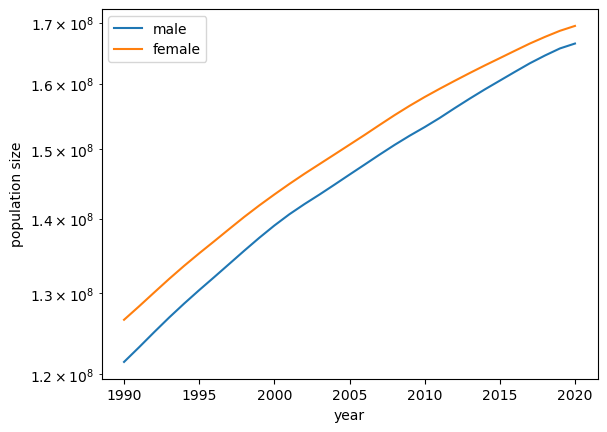

In [62]:
# plot male and female populations over time in us
x = df_usa['year']
y_male = df_usa['total_population_male']
y_female = df_usa['total_population_female']
plt.plot(x,y_male,label='male')
plt.plot(x,y_female,label='female')
plt.yscale("log",base=10)
plt.xlabel('year')
plt.ylabel('population size')
plt.legend()

more females than males, but what is the gap here? hard to tell by this plot

Text(0.5, 0, 'year')

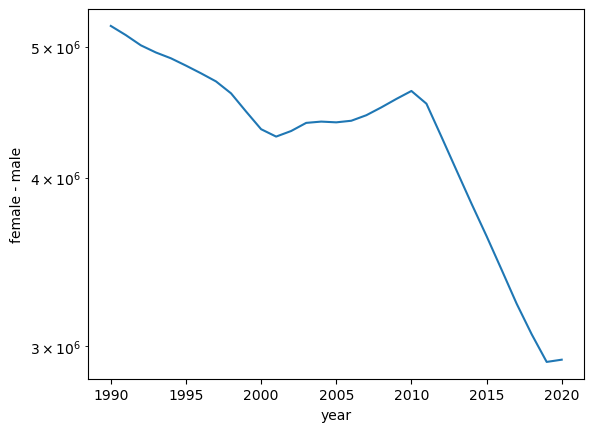

In [63]:
# plot difference of males and females
y_diff = y_female - y_male
plt.plot(x,y_diff)
plt.yscale("log",base=10)
plt.ylabel('female - male')
plt.xlabel('year')

- 1990: 5M more females than males
- 2020: only 3M more females than males
- the difference (females - males) is decreasing over time

## Exercise 2
- goal: quantify the balance and rate of change between rural and urban populations in the USA
- produce two line plots
1. Urban and rural population sizes over time
2. The difference urban and rural populations over time

Write a 1 sentence hypothesis based on your plots

## Rice cultivation dominated by few areas

the majority of human wealth and power is held by a small fraction of people

what about rice?

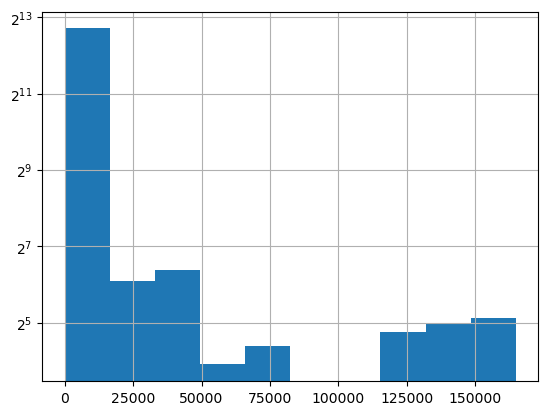

In [64]:
df['rice_cultivation'].hist()
plt.yscale('log',base=2)

most areas produce a small amount of rice while relatively few produce a lot of rice

**heavy-tailed** distributions are infamous in social sciences and empirical network dataset

in fact, many non-negative count data sets (natural numbers [$\mathbb{N}_0$]) are heavy-tailed

let's quantify how important the areas are on the right-hand tail of distribution

The **Gini coefficient** and **Lorenz curve** will quantify the degree of inequality in a distribution.

Lorenz curve

sort $x_1, \ldots, x_n$ from least to most "wealthy"
- x-axis: cumulative fraction of the population
- y-axis: cumulative fraction of total wealth

Gini coefficient
- $x\in \mathbb{R}^n$:= data
- $\bar{x}$: = empirical mean

$G=\frac{\sum_{i=1}^n\sum_{j=1}^n|x_i-x_j|}{2n^2\bar{x}}$

- numerator is sum of pairwise differences
- divide by 2 bc we double count
- divide by $n^2$ to average
  - I feel like we should use $n\choose2$ instead ...
  - $G=\frac{\sum_{i=1}^n\sum_{j=1}^n|x_i-x_j|}{2n(n-1)\bar{x}}$
- divide by $\bar{x}$ s.t. $Range(G) \in [0,1]$ (normalization)
- interpretation
  - $G=0 \rightarrow$ wealth is equally distributed (one for all)
  - $G=1 \rightarrow$ maximal inequality (all for one)

In [65]:

def gini(x, avg='nchoose2'):
  # there are more efficient ways to compute this
  # but the form used above is most interpretable
  n = len(x)
  num = 0
  mean = np.mean(x)
  for i in range(n):
    for j in range(n):
      num += np.abs(x[i] - x[j])
  if avg == 'nchoose2':
      denom = 2*n*(n-1) * mean
  elif avg == 'quad':
      denom = 2*(n**2)*mean
  else:
      raise ValueError('use "nchoose2" or "quad" for denominator scale')
  return num / denom
# takes about 1 min
gini(df['rice_cultivation'].values)

0.8707302318270593

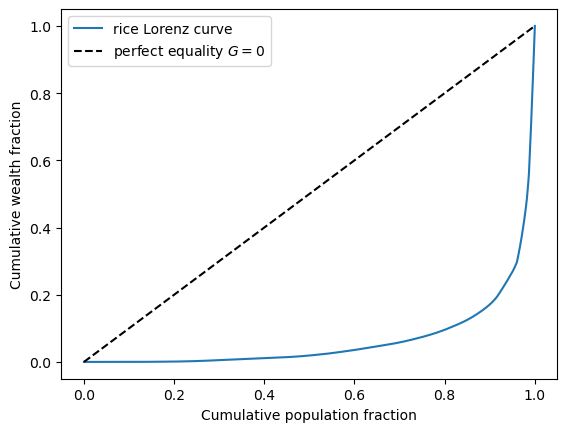

In [66]:
# plot lorenz curve
x = np.sort(df['rice_cultivation'].values)
n = len(x)
# cumulaitve sum vector
cs = np.cumsum(x)
# add 0,0
cs = np.insert(cs, 0, 0)
# normalize cs to [0,1]
cs = cs / cs[-1]
# space our population along the line segment [0,1]
pop = np.linspace(0,1,n+1) # +1 because we added 0,0
# plot
# lorenz curve
plt.plot(pop, cs, label='rice Lorenz curve')
# perfect equality line (G=0)
plt.plot([0,1], [0,1], label="perfect equality $G=0$", color = 'black', linestyle='--')
plt.xlabel('Cumulative population fraction')
plt.ylabel('Cumulative wealth fraction')
plt.legend()


interpretation of rice Lorenz curve
- 20% of areas produce $\approxeq$90% of rice (look at x=0.8,$y\approxeq0.1$ of Lorenz curve)

## Exercise 3

- goal: compute Gini coef. for simulated data
- approach:
  - for zipf and powerlaw distributions (hint: use np.random)
    - sample 1000 values
    - compute Gini coef. and plot Lorenz curve
- time: 10m

# Exercise solutions

## Excerise 1

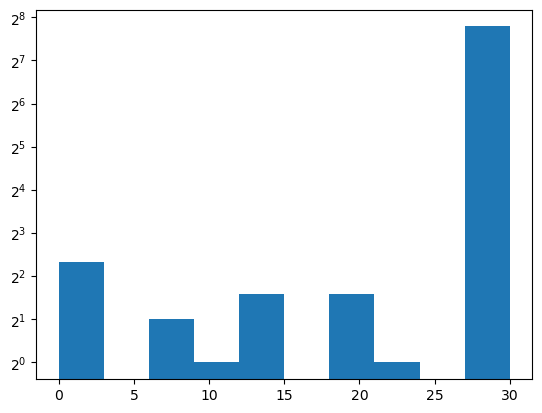

In [67]:
# histogram solution
spans = []
for group, df_group in df.groupby('area'):
    spans.append(df_group['year'].max() - df_group['year'].min())
plt.hist(spans)
plt.yscale('log',base=2)

histogram collapses year data for each area into a single integer: span length.

does not indicate which years are missing

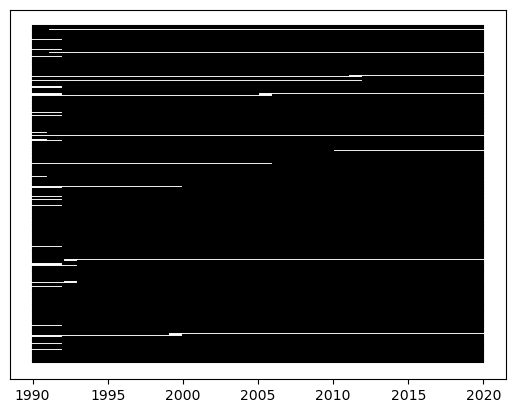

In [71]:
# interval line solution
fig,ax = plt.subplots()
ticks = []
spacing = 1
i=-2
i_prev=0
for group, df_group in df.groupby('area'):
    i = i_prev + spacing
    years = df_group['year'].values
    ax.plot(years, np.repeat(i, len(years)),color='black')
    ticks.append(group)
    i_prev = i
# hide yticks
ax.yaxis.set_visible(False)
# set y axis label
ax.set_ylabel('Countries')
fig.show()


interval plot has fine grain resolution on which years are missing

## Exercise 2

In [72]:
df_usa.head()

,area,year,savanna_fires,forest_fires,crop_residues,rice_cultivation,drained_organic_soils_co2,pesticides_manufacturing,food_transport,forestland,...,manure_management,fires_in_organic_soils,fires_in_humid_tropical_forests,on_farm_energy_use,rural_population,urban_population,total_population_male,total_population_female,total_emission,average_temperature_c
6591,United States of America,1990,1391.1481,1999.5617,19193.1314,11195.520,50713.3546,13772.0,45410.2673,-520573.1593,...,47024.7024,0.0,9.8513,54454.7092,62373717.0,190156233.0,121451448.0,126632284.0,463050.9394,0.733583
6592,United States of America,1991,1391.1481,1999.5617,17574.1126,11029.312,50713.3546,13139.0,44566.9408,-520573.1593,...,48206.0451,0.0,9.8513,54565.6091,61957131.0,193017688.0,123229931.0,128330258.0,473285.7816,0.706333
6593,United States of America,1992,1391.1481,1999.5617,20964.8025,12421.402,50713.3546,14109.0,46198.5933,-520573.1593,...,48416.2439,0.0,9.8513,57469.9273,61539241.0,195915032.0,125081499.0,130093840.0,486026.3425,0.253000
6594,United States of America,1993,1391.1481,1999.5617,16761.5327,11235.602,50566.2744,12948.0,45175.6740,-520573.1593,...,48426.0899,0.0,9.8513,54689.3180,61136396.0,198883790.0,126914111.0,131865642.0,484238.6197,0.153500
6595,United States of America,1994,1391.1481,1999.5617,21370.6468,13151.110,50418.1314,14401.0,46739.0889,-520573.1593,...,49165.7227,0.0,9.8513,55539.8937,60759735.0,201981831.0,128685441.0,133588147.0,509412.4984,0.470250


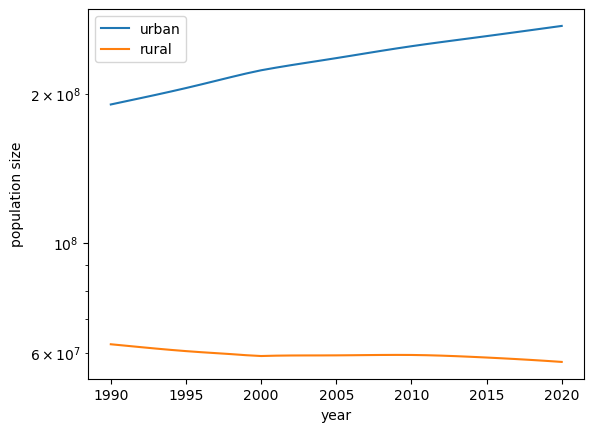

In [73]:
# plot urban and rural populations over time in us
x = df_usa['year']
y_urban = df_usa['urban_population']
y_rural = df_usa['rural_population']
plt.plot(x,y_urban,label='urban')
plt.plot(x,y_rural,label='rural')
plt.yscale("log",base=10)
plt.xlabel('year')
plt.ylabel('population size')
plt.legend()

Text(0.5, 0, 'year')

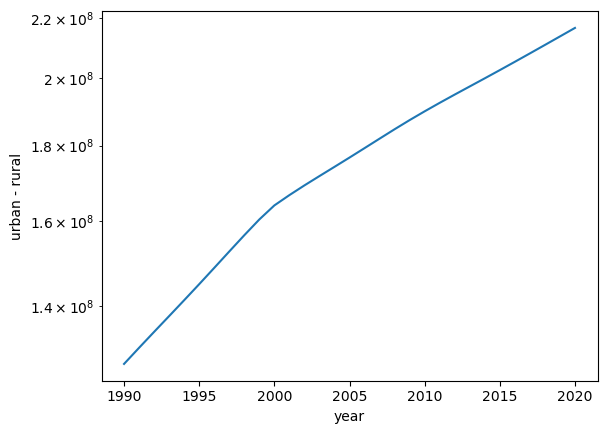

In [74]:
# plot difference of males and females
y_diff = y_urban - y_rural
plt.plot(x,y_diff)
plt.yscale("log",base=10)
plt.ylabel('urban - rural')
plt.xlabel('year')

hypothesis: in the last three decades of the USA, people have been migrating from rural to urban areas

## Exercise 3


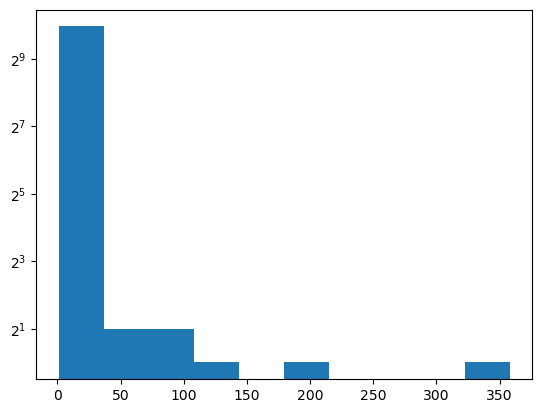

In [75]:
x_zipf = np.random.zipf(a=2,size=1000)
plt.hist(x_zipf)
plt.yscale("log",base=2)


In [76]:
# zipf Gini
gini_zipf = gini(x_zipf)
print("zipf gini: ", gini_zipf)

zipf gini:  0.6202736694539973


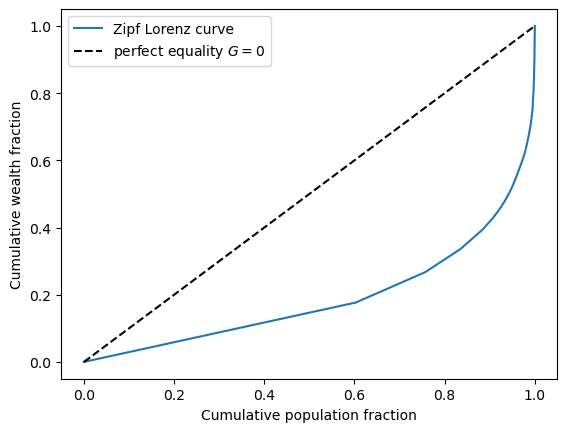

In [77]:
# zipf Lorenz
x_zipf_sort = np.sort(x_zipf)
n = len(x_zipf_sort)
# cumulaitve sum vector
cs = np.cumsum(x_zipf_sort)
# add 0,0
cs = np.insert(cs, 0, 0)
# normalize cs to [0,1]
cs = cs / cs[-1]
# space our population along the line segment [0,1]
pop = np.linspace(0,1,n+1) # +1 because we added 0,0
# plot
# lorenz curve
plt.plot(pop, cs, label='Zipf Lorenz curve')
# perfect equality line (G=0)
plt.plot([0,1], [0,1], label="perfect equality $G=0$", color = 'black', linestyle='--')
plt.xlabel('Cumulative population fraction')
plt.ylabel('Cumulative wealth fraction')
plt.legend()

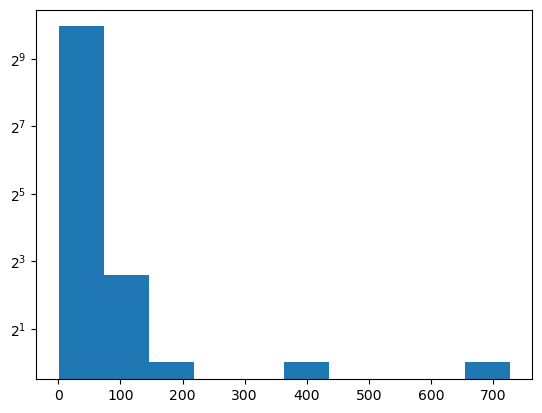

In [78]:
# zipf a = 2
x_zipf = np.random.zipf(2,1000)
plt.hist(x_zipf)
plt.yscale("log",base=2)

In [79]:
# zipf Gini
gini_zipf = gini(x_zipf)
print("zipf gini: ", gini_zipf)

zipf gini:  0.739825818556948


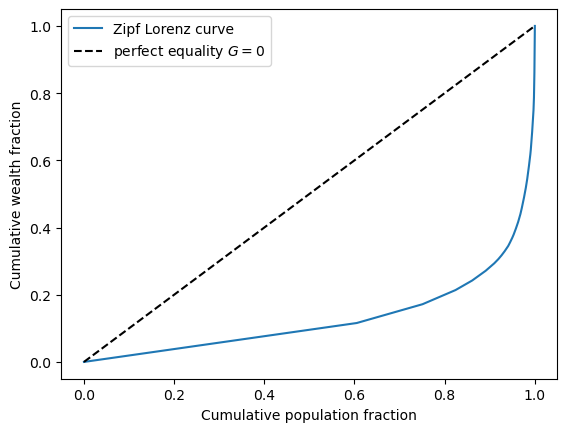

In [80]:
# zipf Lorenz
x_zipf_sort = np.sort(x_zipf)
n = len(x_zipf_sort)
# cumulaitve sum vector
cs = np.cumsum(x_zipf_sort)
# add 0,0
cs = np.insert(cs, 0, 0)
# normalize cs to [0,1]
cs = cs / cs[-1]
# space our population along the line segment [0,1]
pop = np.linspace(0,1,n+1) # +1 because we added 0,0
# plot
# lorenz curve
plt.plot(pop, cs, label='Zipf Lorenz curve')
# perfect equality line (G=0)
plt.plot([0,1], [0,1], label="perfect equality $G=0$", color = 'black', linestyle='--')
plt.xlabel('Cumulative population fraction')
plt.ylabel('Cumulative wealth fraction')
plt.legend()

increasing the $a$ parameter increased the Gini Coefficient and changed the shape of Lorenz curve.

# Instructor notes

from command-line
```
jupyter server
```
copy link into web browser